In [1]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os
import numpy as np
import time, datetime
import matplotlib.pyplot as plt

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros

from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

# Initialize Super Mario environment (in v0.26 change render mode to 'human' to see results on the screen)
if gym.__version__ < '0.26':
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)
else:
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb', apply_api_compatibility=True)

# Limit the action-space to
#   0. walk right
#   1. jump right

env = JoypadSpace(env, [["right"], ["right", "A"]])
# env = JoypadSpace(env, [
#     ['NOOP'],
#     ['right'],
#     ['right', 'A'],
#     ['right', 'B'],
#     ['right', 'A', 'B'],
#     ['A'],
#     ['left']
# ])

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape, antialias=True), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)




class Mario:
    def __init__(self, state_dim, action_dim, save_dir, learning_rate=0.001, gamma=0.99):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = Path(save_dir)
        self.gamma = gamma

        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.net = MarioNet(self.state_dim, self.action_dim).float().to(self.device)

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=learning_rate)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()
            
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)
        self.curr_step += 1
        return action_idx
    
    def update_q_values(self, state, action, next_state, reward, done):

        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()
        
        # Convert to tensors
        state_tensor = torch.tensor(state).to(self.device)
        next_state_tensor = torch.tensor(next_state).to(self.device)
        action_tensor = torch.tensor([action]).long().to(self.device)  # actions are typically long type
        reward_tensor = torch.tensor([reward]).to(self.device)
        done_tensor = torch.tensor([done]).to(self.device)
        done_float_tensor = done_tensor.float()

        # Specify 'online' when calling the forward method of MarioNet
        curr_Q = self.net(state_tensor.unsqueeze(0), 'online').gather(1, action_tensor.unsqueeze(1)).squeeze(1)
        next_Q = self.net(next_state_tensor.unsqueeze(0), 'online').max(1)[0].detach()
        expected_Q = reward_tensor + (1 - done_float_tensor) * self.gamma * next_Q

        # Compute loss
        loss = self.loss_fn(curr_Q, expected_Q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()
    
    def save(self):
        save_path = self.save_dir / f"mario_net.chkpt"
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")
    

    
class MarioNet(nn.Module):
    """
    Structure: input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
    """
    
    def __init__(self, input_dim, output_dim):
        super(MarioNet, self).__init__()
        c, h, w = input_dim
        
        expected_height, expected_width = 84, 84
        if h != expected_height or w != expected_width:
            raise ValueError(f"Expecting input dimensions: {expected_height}x{expected_width}, got: {h}x{w}")

        self.online = self.create_cnn_architecture(c, output_dim)
        self.target = self.create_cnn_architecture(c, output_dim)
        
        self._update_target_network()

    def forward(self, input, model="online"):
        """Forward pass through the specified model: online or target."""
        if model not in ["online", "target"]:
            raise ValueError(f"Model type '{model}' is not valid. Choose 'online' or 'target'.")
        return getattr(self, model)(input)
    
    def create_cnn_architecture(self, input_channels, output_dim):
        """Constructs the CNN architecture."""
        return nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),  # 3136 = 64 * 7 * 7, assuming input size 84x84
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def _update_target_network(self):
        """Updates target network weights to match the online network and freezes target updates."""
        self.target.load_state_dict(self.online.state_dict())
        for param in self.target.parameters():
            param.requires_grad = False
    

class MetricLogger:
    def __init__(self, save_dir):
        self.save_dir = Path(save_dir)
        self.ensure_dir_exists(self.save_dir)
        self.initialize_log_files()

        # History metrics
        self.reset_history_metrics()

        # Timing
        self.record_time = time.time()

    def ensure_dir_exists(self, dir_path):
        dir_path.mkdir(parents=True, exist_ok=True)

    def initialize_log_files(self):
        self.save_log = self.save_dir / "log"
        header = ("{:<8}{:<8}{:<10}{:<15}"
                  "{:<15}{:<15}{:<15}{:<15}{:<20}\n").format(
            'Episode', 'Step', 'Epsilon', 'MeanReward',
            'MeanLength', 'MeanLoss', 'MeanQValue', 'TimeDelta', 'Time')
        with open(self.save_log, "w") as f:
            f.write(header)

        self.file_paths = {
            'reward': "reward_plot.jpg",
            'length': "length_plot.jpg",
            'loss': "loss_plot.jpg",
            'q_value': "q_plot.jpg"
        }
        for key in self.file_paths.keys():
            self.file_paths[key] = self.save_dir / self.file_paths[key]

    def reset_history_metrics(self):
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []

        self.init_episode()
    
    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_loss_count = 0  # Renamed for clarity

    def log_step(self, reward, loss, _):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss is not None:
            self.curr_ep_loss += loss
            self.curr_ep_loss_count += 1  

    def log_episode(self):
        avg_loss = (self.curr_ep_loss / self.curr_ep_loss_count 
                    if self.curr_ep_loss_count else 0)
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        self.ep_avg_losses.append(avg_loss)
        
        self.init_episode()

    def compute_moving_averages(self):
        for metric in ['ep_rewards', 'ep_lengths', 'ep_avg_losses']:
            mean_value = np.round(np.mean(getattr(self, metric)[-100:]), 3)
            moving_avg_attr = 'moving_avg_' + metric
            getattr(self, moving_avg_attr).append(mean_value)

    def record(self, episode, epsilon, step):
        self.compute_moving_averages()
        time_since_last_record = np.round(time.time() - self.record_time, 3)
        self.record_time = time.time()
        current_time_str = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')

        log_msg = (f"{episode:<8d}{step:<8d}{epsilon:<10.3f}"
                   f"{self.moving_avg_ep_rewards[-1]:<15.3f}"
                   f"{self.moving_avg_ep_lengths[-1]:<15.3f}"
                   f"{self.moving_avg_ep_avg_losses[-1]:<15.3f}"
                   f"{time_since_last_record:<15.3f}{current_time_str:>20}\n")
        with open(self.save_log, "a") as f:
            f.write(log_msg)

        print_message = (f"Episode {episode} - "
                     f"Step {step} - "
                     f"Epsilon {epsilon:.3f} - "
                     f"Mean Reward {self.moving_avg_ep_rewards[-1]:.3f} - "
                     f"Mean Length {self.moving_avg_ep_lengths[-1]:.3f} - "
                     f"Mean Loss {self.moving_avg_ep_avg_losses[-1]:.3f} - "
                     f"Time Delta {time_since_last_record:.3f} - "
                     f"Time {current_time_str}")
    
        print(print_message)
        if episode == episodes - 1:  # Check if it's the last episode
            self.plot_final_rewards_graph()
            
    def plot_final_rewards_graph(self):
        plt.figure()
        plt.plot(self.moving_avg_ep_rewards, label='Moving Avg Rewards')
        plt.title('Moving Average of Rewards')
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend()
        plt.show()  t

# Example Usage
logger = MetricLogger("./logs")


use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("Mario_Q-Learning_checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True, exist_ok=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)


C:\Users\Steve\anaconda3\envs\gymenv\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
C:\Users\Steve\anaconda3\envs\gymenv\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
C:\Users\Steve\anaconda3\envs\gymenv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}
Using CUDA: True



Game Terminated: No Flag	Reward: 1608.0, Coins: 1
Episode 0 - Step 373 - Epsilon 1.000 - Mean Reward 1608.000 - Mean Length 373.000 - Mean Loss 11.587 - Time Delta 3.814 - Time 2024-03-10T15:33:50
Game Terminated: No Flag	Reward: 1686.0, Coins: 1
Game Terminated: No Flag	Reward: 231.0, Coins: 1
Game Terminated: No Flag	Reward: 1000.0, Coins: 1
Game Terminated: No Flag	Reward: 238.0, Coins: 1
Game Terminated: No Flag	Reward: 768.0, Coins: 0
Game Terminated: No Flag	Reward: 760.0, Coins: 1
Game Terminated: No Flag	Reward: 585.0, Coins: 0
Game Terminated: No Flag	Reward: 607.0, Coins: 0
Game Terminated: No Flag	Reward: 1627.0, Coins: 2
Game Terminated: No Flag	Reward: 222.0, Coins: 0
Game Terminated: No Flag	Reward: 946.0, Coins: 0
Game Terminated: No Flag	Reward: 884.0, Coins: 1
Game Terminated: No Flag	Reward: 779.0, Coins: 0
Game Terminated: No Flag	Reward: 231.0, Coins: 0
Game Terminated: No Flag	Reward: 671.0, Coins: 1
Game Terminated: No Flag	Reward: 961.0, Coins: 1
Game Terminated:

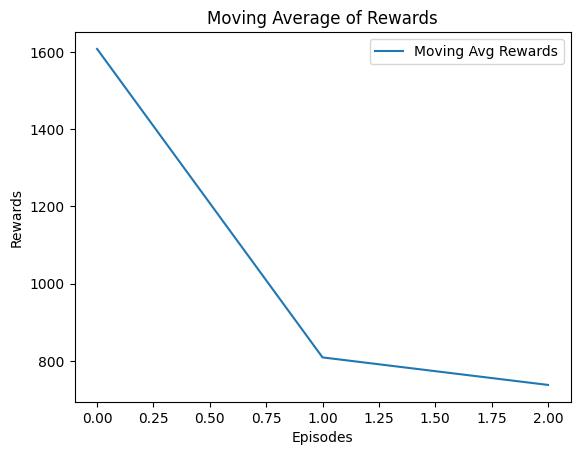

In [2]:
# def potential(info):
#     # Example potential based on Mario's x-position to encourage rightward progress
#     # Assuming 'x_pos' is a key in the 'info' dict that tracks Mario's position
#     return info.get('x_pos', 0)
    

episodes = 40
for e in range(episodes):
    state = env.reset()
    total_reward = 0
    while True:
        # Run agent on the state
        action = mario.act(state)
        
        # Agent performs action
        next_state, reward, done, trunc, info = env.step(action)
        
        # Accumulate reward with any additional environmental factors, such as coins
        coins_collected = info.get('coins', 0)
        reward += coins_collected
        total_reward += reward

        # Q-learning update
        loss = mario.update_q_values(state, action, next_state, reward, done)

        # Logging
        logger.log_step(reward, loss, None)  # q value (None) is not used in standard Q-learning

        # Update state
        state = next_state

        # Check if end of game
        if done or info.get("flag_get", False):  # Ensure 'flag_get' key exists with .get method
            if info.get("flag_get", False):
                print(f"Flag Gotten\tReward: {total_reward}")
            if done:
                print(f"Game Terminated: No Flag\tReward: {total_reward}, Coins: {coins_collected}")
            break

    logger.log_episode()

    if (e % 20 == 0) or (e == episodes - 1):
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)
